In [2]:
import math
import sys
import iris
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
import netCDF4
from matplotlib import ticker, cm
import matplotlib.colors as mcols
from matplotlib.colors import from_levels_and_colors
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [13]:
import ephem

In [3]:
# For a given timestep, need to determine SO2 uptake field:
# 24 x 385 x 1024 grid boxes
# 1)Take mass of SO2, convert to molecules. 
# 2)Estimate number of ash particles using mass, density, PSD midpoint (see effective diameter formula). 
# NEED TO USE INDIVIDUAL ASH PARTICLE SIZE CUBES FOR THIS!
# 3)Apply initial uptake coefficient (5.0–10.8 × 10**-2)
# 4)Calculate total ash surface area from particle number estimate. (see ASH/INP example)
# 5)Apply saturation coverage (1.2-1.8 x 10**13 [CHECK] molecules cm-2), remembering that this is a function of BET SA so must convert. This is upper limit – so value for the grid box is either that calculated from previous steps or saturation value, whichever is lower.
# 6)Start to think about integrating other parameters: create fields using temp, RH metadata. 

#define steps 1-5 in single function

In [4]:
#LOOK AT 75PPB THRESHOLD
#PLAY AROUND WITH OVERLAP GRAPH TO FIND LOWER THRESHOLD

In [5]:
cd /shared/netscratch/jd876

/shared/netscratch/jd876


In [6]:
volume_array = np.load('/home/rh721/Volumearray.npy') #m^3

In [7]:
nc_files_SO2=sorted(glob.glob('/scratch/rh721/netscratch/SO2cont*.nc'))
nc_files_ash = sorted(glob.glob('/scratch/rh721/netscratch/ASH*.nc'))
nc_files_SO2mixingratio = sorted(glob.glob('/scratch/rh721/netscratch/SO2mixingratio*.nc'))
list_timesteps=sorted(glob.glob('/shared/netscratch/jd876/Fields_grid82_C1_T*.txt'))
nc_files_RH = sorted(glob.glob('/scratch/rh721/netscratch/RH*'))        
nc_files_cloud = sorted(glob.glob('/scratch/rh721/netscratch/CLOUD*'))       

In [8]:
p = 30 #22nd April 00:00
SO2cube = iris.load_cube(nc_files_SO2[p])
SO2data = SO2cube.data
ashcube = iris.load_cube(nc_files_ash[p])
ashdata = ashcube.data

In [9]:
alt = SO2cube.coord('altitude').points
lat = SO2cube.coord('latitude').points
lon = SO2cube.coord('longitude').points

In [10]:
#differences plots
#calculate percentage uptake of total SO2
#plot 3 panel graph comparing ash, SO2, uptake cross sections
#produce animations


In [11]:
def ash_molecule_calc(VAdiam,VAmass): 
    VAparticlevolume = (4/3) * math.pi * (VAdiam/2)**3 # ash particle volume assuming sphere
    VAparticleSA = (4) * math.pi * (VAdiam/2)**2 * 2 # ash particle SA - multiplied by 2 assuming ash sphericity is actually 0.5
    VAvolume = VAmass/2300000 # ash volume in m^3 (mass/density in g/m^3) 
    VAparticlenumber = VAvolume/VAparticlevolume # ash particle number
    return VAparticlenumber


NameError: name 'ephem' is not defined

In [20]:
home = ephem.Observer()
fractionaluptake = np.zeros(len(list_timesteps))
for p in range(20, 40):
    #read in data
    field_file = nc_files_SO2[p]
    
    SO2cube = iris.load_cube(nc_files_SO2[p])
    SO2data = SO2cube.data
    SO2data[SO2data == np.inf] = 0
    SO2data[SO2data == np.nan] = 0
    ashcube = iris.load_cube(nc_files_ash[p])
    ashdata = ashcube.data
    ashdata[ashdata == np.inf] = 0
    ashdata[ashdata == np.nan] = 0
    RHcube = iris.load_cube(nc_files_RH[p])
    RHdata = RHcube.data
    RHdata[RHdata == np.inf] = 0
    RHdata[RHdata == np.nan] = 0
    cloudcube = iris.load_cube(nc_files_cloud[p])
    clouddata = cloudcube.data
    clouddata[clouddata == np.inf] = 0
    clouddata[clouddata == np.nan] = 0
    
    
    Ti_Si_ratio = 0.5/25.5
    
    
    SO2massfield = volume_array * SO2data/10**6 #in g
    ASHmassfield = volume_array * ashdata/10**6 #in g
    
    #calculate no. molecules of SO2 in each gridbox
    SO2molarmass = 64.066 #g/mol
    Na = 6.0221409 * 10**23 #molecules/mol
    SO2field = np.divide(SO2massfield, SO2molarmass) *  Na
    SO2moleculefield = SO2field.data
    
    cubes = iris.load(list_timesteps[p])
    
    
    # assuming 5% distal ash fraction
    cubeVA0 = cubes[0] * 0.05 #0.10 - 2.00 um
    cubeVA1 = cubes[1] * 0.05 #2.00 - 3.90 um
    cubeVA2 = cubes[2] * 0.05 #3.90 - 7.80 um
    cubeVA3 = cubes[3] * 0.05 #7.80 - 15.60 um
    cubeVA4 = cubes[4] * 0.05 #15.60 - 31.20 um 
    cubeVA5 = cubes[5] * 0.05 #31.20 - 62.50 um
    cubeVA6 = cubes[6] * 0.05 #62.50 - 125.00 um
    
    VAdiams = ((6.34 * 10**-7),(2.85 * 10**-6),(5.63 * 10**-6),(1.13 * 10**-5),(2.25 * 10**-5),(4.51 * 10**-5),(9.02 * 10**-5))
    VAconcs = (cubeVA0.data, cubeVA1.data, cubeVA2.data, cubeVA3.data, cubeVA4.data, cubeVA5.data, cubeVA6.data)
    #masses in grams
    VAmasses = (cubeVA0.data * volume_array, cubeVA1.data * volume_array, cubeVA2.data * volume_array, cubeVA3.data * volume_array, 
                cubeVA4.data * volume_array, cubeVA5.data * volume_array, cubeVA6.data * volume_array)
    
    ASH0 = ash_molecule_calc(VAdiams[0],VAmasses[0]) 
    ASH1 = ash_molecule_calc(VAdiams[1],VAmasses[1]) 
    ASH2 = ash_molecule_calc(VAdiams[2],VAmasses[2]) 
    ASH3 = ash_molecule_calc(VAdiams[3],VAmasses[3]) 
    ASH4 = ash_molecule_calc(VAdiams[4],VAmasses[4]) 
    ASH5 = ash_molecule_calc(VAdiams[5],VAmasses[5]) 
    ASH6 = ash_molecule_calc(VAdiams[6],VAmasses[6]) 
    ASHmoleculefield = ASH0 + ASH1 + ASH2 + ASH3 + ASH4 + ASH5 + ASH6 #total number of ash particles 
    
    #calculating ash particle geometric SA for each bin, sphericity 0.5
    ASH0particleSA = (4) * math.pi * (VAdiams[0]/2)**2
    ASH1particleSA = (4) * math.pi * (VAdiams[1]/2)**2
    ASH2particleSA = (4) * math.pi * (VAdiams[2]/2)**2
    ASH3particleSA = (4) * math.pi * (VAdiams[3]/2)**2
    ASH4particleSA = (4) * math.pi * (VAdiams[4]/2)**2
    ASH5particleSA = (4) * math.pi * (VAdiams[5]/2)**2
    ASH6particleSA = (4) * math.pi * (VAdiams[6]/2)**2
    
    #this gives array of total geometric ash SA in cm^2 in each grid box, (convert to BET by *~100 [C. M. Wygel et al.])
    ASHtotalSAfield =  10000 * ((ASH0particleSA * ASH0) + (ASH1particleSA * ASH1) + (ASH2particleSA * ASH2) + 
                                    (ASH3particleSA * ASH3) + (ASH4particleSA * ASH4) + (ASH5particleSA * ASH5) + (ASH6particleSA * ASH6)) 
   
    initialuptake = 0.05
    saturationuptake = 1.2*10**13 #molecules/cm^2
    uptakefield = np.zeros((24, 385, 1025))
    ashSAcolumn = np.nansum(ASHtotalSAfield[:,:,:],axis=0)

    for i in range(len(volume_array[0,:,0])):    # loop over latitude
        for j in range(len(volume_array[0,0,:])): # loop over longitude
            if ashSAcolumn[i,j] > 0:
                for k in range(len(volume_array[:,0,0])): # loop over altitude

                    #day/night analysis
                    home.lon = str(lon[j])
                    home.lat = str(lat[i])
                    home.date = (int(field_file[-15:-11]), int(field_file[-11:-9]), int(field_file[-9:-7]), int(field_file[-7:-5]))
                    home.elevation = alt[k]
                    sun = ephem.Sun()
                    sun.compute(home)
                    
                    #J value scales linearly with cloud cover fraction
                    if sun.alt > -18: #day time if sun above 18 degrees below horizon
                        J = 4.5*0.001 * (1 - clouddata[k,i,j])
                    else:
                        J = 0 #night time


                    if(ASHtotalSAfield[k,i,j] !=0):
                        #Apply initial uptake coefficient and calculate total uptake per grid box
                        uptake = initialuptake * np.divide(SO2moleculefield[k,i,j], ASHtotalSAfield[k,i,j]) #uptake in molecules/cm^2

                        photoenhancedsaturationuptake = saturationuptake *  6.1 * (1 + 7.76 * 0.01 * RHdata[k,i,j]) * (1 + 480.5 * J) * Ti_Si_ratio            
                        if(uptake < photoenhancedsaturationuptake):
                                uptakefield[k,i,j] = uptake
                        else:
                                uptakefield[k,i,j] = photoenhancedsaturationuptake
                                             
                            
                                
    uptakefield[uptakefield == np.inf] = 0
    uptakefield[uptakefield == np.nan] = 0
    np.save('/scratch/rh721/netscratch/uptakefield' + str(p), uptakefield)
                    

    #uptake field in molecules/cm^2, i.e. molecules of SO2 taken up per cm^2 BET surface area of ash
 
    #calculate fractional uptake of SO2 using uptake field
    absoluteSO2uptake = np.nansum(uptakefield * ASHtotalSAfield) 
    SO2totalmolecules = np.nansum(SO2moleculefield)
     
    fractionaluptake[p] = np.divide(absoluteSO2uptake, SO2totalmolecules) 
    
    
    print('timestep: ' + str(p) + ', fractionaluptake: '+ str(fractionaluptake[p]))

timestep: 20, fractionaluptake: 0.00012470870211509828
timestep: 21, fractionaluptake: 0.00012461308489706869
timestep: 22, fractionaluptake: 0.00012742670055498553
timestep: 23, fractionaluptake: 0.00012766854591650888
timestep: 24, fractionaluptake: 0.0001242137013655635
timestep: 25, fractionaluptake: 0.0001212948822902794
timestep: 26, fractionaluptake: 0.000119241890782569
timestep: 27, fractionaluptake: 0.00011731851369060522
timestep: 28, fractionaluptake: 0.00011132935527106551
timestep: 29, fractionaluptake: 0.0001049548287216087
timestep: 30, fractionaluptake: 9.872036671112866e-05
timestep: 31, fractionaluptake: 9.42211094618629e-05
timestep: 32, fractionaluptake: 8.743531062534116e-05
timestep: 33, fractionaluptake: 8.116008751026913e-05
timestep: 34, fractionaluptake: 7.552064147328845e-05


/home/rh721/.conda/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in multiply


timestep: 35, fractionaluptake: 7.224398028744248e-05


/home/rh721/.conda/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in multiply


timestep: 36, fractionaluptake: 6.83090806408659e-05


/home/rh721/.conda/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in multiply


timestep: 37, fractionaluptake: 6.453038658665179e-05
timestep: 38, fractionaluptake: 6.313377051332985e-05
timestep: 39, fractionaluptake: 6.135182063174842e-05


/home/rh721/.conda/envs/iris/lib/python3.6/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in multiply


In [21]:
np.save('/home/rh721/fractionaluptake_0-39', fractionaluptake)

In [163]:
home.date = (2020, month, day hour)

<ephem.Observer date='2010/4/14 00:00:00' epoch='2000/1/1 12:00:00' lon='-179:17:48.8' lat='0:28:07.5' elevation=1250.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

In [33]:
time_array = np.load('time_array.npy')

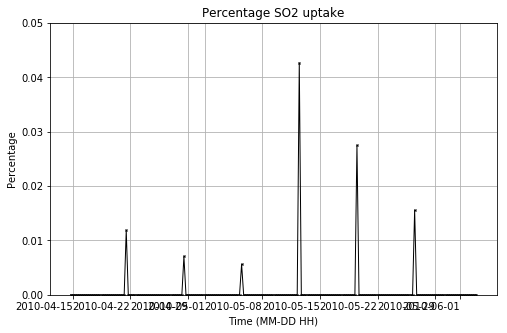

In [55]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(time_array[0:199], fractionaluptake *100, '-x', markersize = '2', color = 'k', lw = 1) # x-axis data, y-axis data, symbol, colour, linewidth)
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor") # set x-axis limit
ax.set_ylim(0,0.05) # set y-axis limit
ax.grid() # add grid
ax.set_ylabel('Percentage') # add y-axis label
ax.set_xlabel('Time (MM-DD HH)') # add x-axis label
ax.set_title('Percentage SO2 uptake') # add title 
plt.show()
 

In [47]:
time_array = np.zeros(len(nc_files_SO2), dtype = 'datetime64[s]')
for i in range(len(nc_files_SO2)):
    SO2_file = nc_files_SO2[i] # store the path to the ASH file
    SO2cube = iris.load_cube(SO2_file) # load the ASH file into a cube
    SO2data = SO2cube.data 
    # get the time from each ASH .nc file and save it in the time_array:
    nc_SO2_file = netCDF4.Dataset(SO2_file)
    time = nc_SO2_file['time'] # extract the time from the ASH .nc file
    time_data = time[:].data
    time_string = pd.to_datetime(time_data/24, unit='D', origin=pd.Timestamp('1970-01-01')) # convert time to the proper format
    time_array[i] = time_string # fill the time_array at the given index with the time
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201


In [51]:
time_array

array(['2010-04-14T12:00:00', '2010-04-14T18:00:00',
       '2010-04-15T00:00:00', '2010-04-15T06:00:00',
       '2010-04-15T12:00:00', '2010-04-15T18:00:00',
       '2010-04-16T00:00:00', '2010-04-16T06:00:00',
       '2010-04-16T12:00:00', '2010-04-16T18:00:00',
       '2010-04-17T00:00:00', '2010-04-17T06:00:00',
       '2010-04-17T12:00:00', '2010-04-17T18:00:00',
       '2010-04-18T00:00:00', '2010-04-18T06:00:00',
       '2010-04-18T12:00:00', '2010-04-18T18:00:00',
       '2010-04-19T00:00:00', '2010-04-19T06:00:00',
       '2010-04-19T12:00:00', '2010-04-19T18:00:00',
       '2010-04-20T00:00:00', '2010-04-20T06:00:00',
       '2010-04-20T12:00:00', '2010-04-20T18:00:00',
       '2010-04-21T00:00:00', '2010-04-21T06:00:00',
       '2010-04-21T12:00:00', '2010-04-21T18:00:00',
       '2010-04-22T00:00:00', '2010-04-22T06:00:00',
       '2010-04-22T12:00:00', '2010-04-22T18:00:00',
       '2010-04-23T00:00:00', '2010-04-23T06:00:00',
       '2010-04-23T12:00:00', '2010-04-23T18:0